In [5]:
import geopandas as gpd
import warnings
import os
import json
import pandas as pd
import tqdm
import math
import numpy as np
import seaborn as sns
from shapely import wkt
import matplotlib.pyplot as plt
import math
warnings.filterwarnings('ignore')

In [ ]:
plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'axes.titlesize': 13})
plt.rcParams.update({'axes.labelsize': 13})
# size of the numbers on the axes
plt.rcParams.update({'xtick.labelsize': 9})
plt.rcParams.update({'ytick.labelsize': 9})
colors = sns.color_palette('husl', 10)

In [2]:
base_path = os.getcwd()
data_path = os.path.join(base_path, 'EV_input')

In [3]:
muni_geo = gpd.read_file('municipality_boundary.geojson')
zones = gpd.read_file(os.path.join(data_path, 'nine_zones 2.geojson'))

##### Step 1： map BFS number

In [4]:
# read the original data
CP = pd.read_csv(os.path.join(data_path, 'CP_y4.csv'), header=None)
FE = pd.read_csv(os.path.join(data_path, 'FE_y4.csv'), header=None)
PD = pd.read_csv(os.path.join(data_path, 'PD_y4.csv'), header=None)
PU = pd.read_csv(os.path.join(data_path, 'PU_y4.csv'), header=None)

In [8]:
# check if the first column of CP FE PD PU is the same
print('the columns of CP and FE are the same:', all(CP[0]==FE[0]))
print('the columns of CP and PD are the same:', all(CP[0]==PD[0]))
print('the columns of CP and PU are the same:', all(CP[0]==PU[0]))

the columns of CP and FE are the same: True
the columns of CP and PD are the same: True
the columns of CP and PU are the same: True


In [9]:
# print the municipalities that appear in zones file but not in CP file
print('Municipalities that appear in zones file but not in EV file: ', set(zones['NAME']) - set(CP[0]))

Municipalities that appear in zones file but not in EV file:  {'Staatswald Galm', 'Comunanza Capriasca/Lugano', 'Comunanza Cadenazzo/Monteceneri'}


In [11]:
# This function maps zone names in the input data to their corresponding BFS numbers 
# based on a provided zones mapping, ensuring data integrity and reordering columns.
# - It copies the input data to avoid modifying the original.
# - Maps the 'BFS_NUMMER' using the 'NAME' column of the zones DataFrame.
# - Removes the original zone name column, reorders columns, renames 'BFS_NUMMER' to 'BFS', 
#   converts it to integer type, and sorts the data by BFS.
# - Warns the user if there are any NaN values in the resulting BFS column.
# Returns a cleaned and mapped DataFrame.

def map_BFS(data, zones):
    df = data.copy()
    df['BFS_NUMMER'] = zones.set_index('NAME').loc[df[0].values].BFS_NUMMER.values
    df = df.drop(columns=[0])
    df = df[['BFS_NUMMER'] + [col for col in df.columns if col != 'BFS_NUMMER']]
    df.rename(columns={'BFS_NUMMER': 'BFS'}, inplace=True)
    df['BFS'] = df['BFS'].astype('int')
    df = df.sort_values('BFS')
    df.reset_index(drop=True, inplace=True)
    
    if df['BFS'].isna().sum() > 0:
        print('There are NaN values in the BFS_NUMMER column')
    return df
CP_mapped = map_BFS(CP, zones)
FE_mapped = map_BFS(FE, zones)
PD_mapped = map_BFS(PD, zones)
PU_mapped = map_BFS(PU, zones)

##### Step 2: Representative week

In [7]:
# Function: month_day_hour_rename
# This function renames the columns of the input data to represent a detailed time structure,
# including month, week in month, day of the week, and hour of the day.
# - It computes the time attributes based on a 24-hour day structure and the number of days in each month.
# - Constructs column names in the format "month_week_day_hour".
# - Retains the 'BFS' column, ensuring it appears first in the DataFrame.
# Returns a DataFrame with renamed columns for finer time granularity.
def month_day_hour_rename(data):
    df = data.copy()
    df_renamed = df.drop(columns=['BFS'])
    day_hour = 24
    month_info = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    column_names = []
    for i in range(len(df_renamed.columns)):
        hour_of_year = i
        month = 1
        day_of_year = hour_of_year // day_hour + 1
        hour = hour_of_year % day_hour
        # The first day of the year is 6 (Saturday)
        day_of_week = (day_of_year + 4) % 7 + 1

        for days_in_month in month_info:
            if day_of_year <= days_in_month:
                break
            day_of_year -= days_in_month
            month += 1

        week_in_month = math.ceil(day_of_year / 7)
        day_in_week = (day_of_year - 1) % 7 + 1
        column_name = f"{month}_{week_in_month}_{day_of_week}_{hour}"
        column_names.append(column_name)
    df_renamed.columns = column_names
    df_renamed['BFS'] = df['BFS']
    df_renamed = df_renamed[['BFS'] + [col for col in df_renamed.columns if col != 'BFS']]
    return df_renamed

# Function: month_day_rename
# This function renames the columns of the input data to represent a time structure
# at a coarser granularity, including only month, week in month, and day of the week.
# - It calculates time attributes based on the number of days in each month and a 7-day week structure.
# - Constructs column names in the format "month_week_day".
# - Retains the 'BFS' column, ensuring it appears as the first column in the DataFrame.
# Returns a DataFrame with renamed columns for simpler time granularity.

def month_day_rename(data_FE):
    df = data_FE.copy()
    df_renamed = df.drop(columns=['BFS'])
    month_info = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    column_names = []

    for i in range(len(df_renamed.columns)):
        day_of_year = i
        # The first day of the year is 6 (Saturday)
        day_of_week = (day_of_year + 5)%7+1

        month = 1
        for days_in_month in month_info:
            if day_of_year < days_in_month:
                break
            day_of_year -= days_in_month
            month += 1

        week_in_month = math.ceil((day_of_year + 1) / 7)
        day_in_week = (day_of_year % 7) + 1

        column_name = f"{month}_{week_in_month}_{day_of_week}"
        column_names.append(column_name)

    df_renamed.columns = column_names
    df_renamed.insert(0, 'BFS', df['BFS'])
    return df_renamed


In [6]:
# Function: rename_columns
# This function renames columns of the input DataFrame based on specified regex patterns and replacement rules.
# - It iterates over all columns, applying the first matching rule from a dictionary of renaming rules.
# - Stops checking further rules once a match is found to ensure efficient renaming.
# Returns a DataFrame with renamed columns, reflecting the specified adjustments.
def rename_columns(df):
    import re
    df_renamed = df.copy()
    # Take the first week of Jan, Dec, Apr, Jun as samples
    renaming_rules = {
        r'^1_1_': '2_',
        r'^12_1_': '1_',
        r'^4_1_': '3_',
        r'^6_1_': '4_',
    }
    new_columns = []
    for col in df_renamed.columns:
        new_col = col
        for pattern, replacement in renaming_rules.items():
            if re.match(pattern, col):
                new_col = re.sub(pattern, replacement, col)
                break  # Stop checking other rules once a match is found
        new_columns.append(new_col)
    df_renamed.columns = new_columns
    return df_renamed

# Function: select_columns
# This function selects specific time-based columns (e.g., certain weeks of specific months) from the input data.
# - Uses the `month_day_hour_rename` function to rename columns for detailed time granularity.
# - Filters columns that match patterns for the first week of January, December, April, and June.
# - Retains the 'BFS' column and renames selected columns using `rename_columns`.
# Returns a DataFrame with only the selected and renamed columns.
def select_columns(data):
    CP_mapped_renamed = month_day_hour_rename(data)
    CP_mapped_keep = CP_mapped_renamed[CP_mapped_renamed.columns[CP_mapped_renamed.columns.str.startswith('12_1') |
                                                                CP_mapped_renamed.columns.str.startswith('1_1') |
                                                                CP_mapped_renamed.columns.str.startswith('4_1') |
                                                                CP_mapped_renamed.columns.str.startswith('6_1')]]
    CP_mapped_keep = CP_mapped_renamed[['BFS'] + list(CP_mapped_keep.columns)]
    CP_mapped_keep = rename_columns(CP_mapped_keep)
    return CP_mapped_keep



# Function: select_columns_FE
# Similar to `select_columns`, but operates on coarser time granularity using `month_day_rename`.
# - Renames columns to represent month, week, and day granularity.
# - Filters columns matching specific patterns for the first week of January, December, April, and June.
# - Retains the 'BFS' column and renames selected columns using `rename_columns`.
# Returns a DataFrame with only the selected and renamed columns.
def select_columns_FE(data):
    FE_mapped_renamed = month_day_rename(data)
    FE_mapped_keep = FE_mapped_renamed[FE_mapped_renamed.columns[FE_mapped_renamed.columns.str.startswith('12_1') |
                                                                FE_mapped_renamed.columns.str.startswith('1_1') |
                                                                FE_mapped_renamed.columns.str.startswith('4_1') |
                                                                FE_mapped_renamed.columns.str.startswith('6_1')]]
    FE_mapped_keep = FE_mapped_renamed[['BFS'] + list(FE_mapped_keep.columns)]
    FE_mapped_keep = rename_columns(FE_mapped_keep)
    return FE_mapped_keep

In [12]:
CP_mapped_selected = select_columns(CP_mapped)
PD_mapped_selected = select_columns(PD_mapped)
PU_mapped_selected = select_columns(PU_mapped)
FE_mapped_selected = select_columns_FE(FE_mapped)

In [13]:
base_save_path = os.path.join(base_path, 'EV_output', 'EV_municipality')  
def save_municipality_file(i):
    BFS = CP_mapped_selected.loc[i, 'BFS']
    save_path = os.path.join(base_save_path, str(BFS))
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    # first file
    df = pd.DataFrame(columns=['week', 'day', 'hour', 'CP_value', 'PD_value', 'PU_value'])
    for j in range(len(CP_mapped_selected.columns)-1):
        j = j + 1
        week, day, hour = CP_mapped_selected.columns[j].split('_')
        CP_value, PD_value, PU_value = CP_mapped_selected.loc[i, CP_mapped_selected.columns[j]], PD_mapped_selected.loc[i, PD_mapped_selected.columns[j]], PU_mapped_selected.loc[i, PU_mapped_selected.columns[j]]
        df = pd.concat([df, pd.DataFrame([[week, day, hour, CP_value, PD_value, PU_value]], columns=df.columns)])
    df['week'] = df['week'].astype('int')
    df['day'] = df['day'].astype('int')
    df['hour'] = df['hour'].astype('int')
    df = df.sort_values(['week', 'day', 'hour'])
    df.reset_index(drop=True, inplace=True)
    
    # second file
    df_EP = pd.DataFrame(columns=['week', 'CP_sum_value'])
    for i in range(4):
        week = i + 1
        value = sum(df[df['week']==week]['CP_value'])
        df_EP = pd.concat([df_EP, pd.DataFrame([[week, value]], columns=df_EP.columns)])
    
    # third file
    df_FE = pd.DataFrame(columns=['week', 'day', 'FE_value'])
    for j in range(len(FE_mapped_selected.columns)-1):
        j = j + 1
        week, day = FE_mapped_selected.columns[j].split('_')
        FE_value = FE_mapped_selected.loc[i, FE_mapped_selected.columns[j]]
        df_FE = pd.concat([df_FE, pd.DataFrame([[week, day, FE_value]], columns=df_FE.columns)])
    df_FE['week'] = df_FE['week'].astype('int')
    df_FE['day'] = df_FE['day'].astype('int')
    df_FE = df_FE.sort_values(['week', 'day'])
    df_FE.reset_index(drop=True, inplace=True)
        
    df.to_csv(os.path.join(save_path, f'{BFS}_CP_PD_PU.csv'), index=False)
    df_EP.to_csv(os.path.join(save_path, f'{BFS}_EP.csv'), index=False)
    df_FE.to_csv(os.path.join(save_path, f'{BFS}_FE.csv'), index=False)
    return df, df_EP, df_FE

In [37]:
for i in range(len(CP_mapped_selected)):
    df, df_EP, df_FE= save_municipality_file(i)

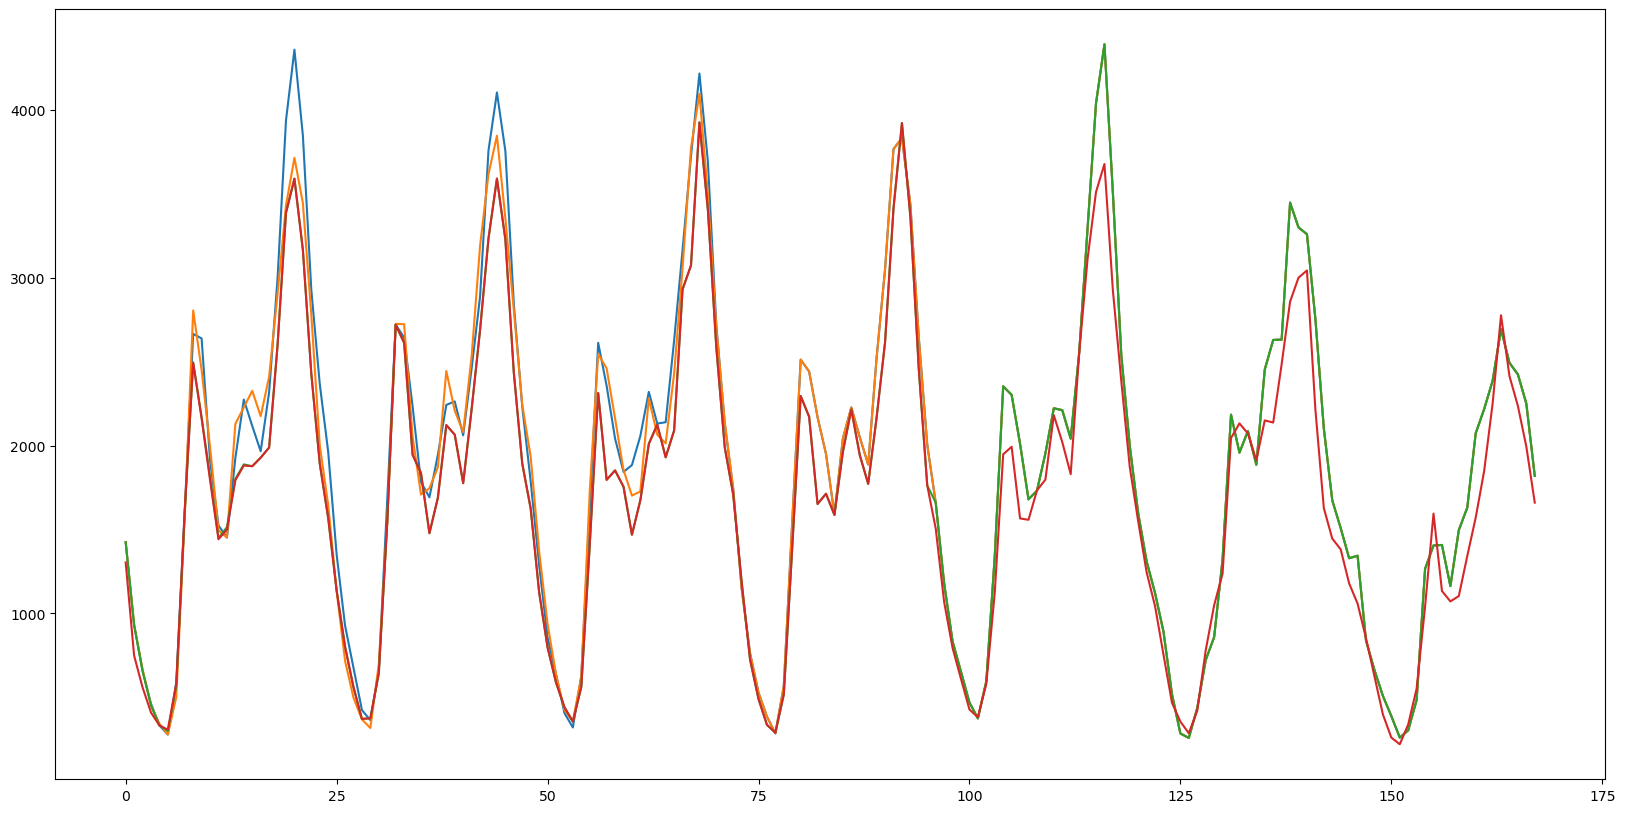

In [38]:
n=168
plt.figure(figsize=(20, 10))
plt.plot(df['CP_value'].iloc[0:n], label = 'First week')
plt.plot(df['CP_value'].iloc[n:2*n].values, label = 'Second week')
plt.plot(df['CP_value'].iloc[2*n:3*n].values, label = 'Third week')
plt.plot(df['CP_value'].iloc[3*n:].values, label = 'Fourth week')
plt.xlabel('Hour')
plt.ylabel('CP value')
plt.legend()
plt.show()

##### Step 4: Consumption distribution
Consider that the EV power consumption is distributed proportionately to the conventional load of the LV nodes in the given municipalities. Get the maximum value of CP (base EV consumption) and PD (upper EV power consumption).\
With these values, obtain the nodal distribution of maximum CP consumption and maximum PD consumption.  Get statistical descriptors of these distributions for the municipalities. 


In [ ]:
# Function: concat_all_grids
# **Description**:
# This function aggregates node-level data for a set of grids, calculating the demand (`el_dmd`) 
# and its percentage contribution relative to the total demand across all grids.

# **Arguments**:
# - `grid_ids` (list): A list of grid IDs to process. Each ID represents a grid, and IDs without an underscore are skipped.
# - `path` (str): The directory path where node files for each grid are located. Each node file is expected to be a GeoDataFrame.

# **Returns**:
# - `node_total` (pd.DataFrame): A DataFrame containing the following columns:
#   - `grid_name`: The name of the grid.
#   - `node_name`: The node identifier (from the 'osmid' column).
#   - `dmd`: The demand at the node (from the 'el_dmd' column, defaulted to 0 if missing).
#   - `percentage`: The percentage of the node's demand relative to the total demand across all nodes in all grids.
# - If no valid grids are found, an empty DataFrame is returned.

# **Additional Notes**:
# - For grids missing the 'osmid' column, the function skips processing.
# - The `el_dmd` column is initialized to zero for grids where it is not present.
# - The function prints a message when encountering single-node grids or empty grids.

def concat_all_grids(grid_ids, path):
    node_total = pd.DataFrame()
    for n in range(len(grid_ids)):
        i = grid_ids[n]
        if '_' not in i:
            print('Single node, skip grid:', i)
            continue
        node_id = i+"_nodes"
        node = gpd.read_file(path+node_id)
        if 'el_dmd' not in node.columns:
            node['el_dmd'] = 0
        dmd = node['el_dmd']
        if 'osmid' not in node.columns:
            continue    
        grid_name = i
        node_name = node['osmid']
        node_total = pd.concat([node_total, pd.DataFrame({'grid_name':grid_name, 'node_name':node_name, 'dmd':dmd})], ignore_index=True)
        node_total['dmd'] = node_total['dmd'].astype(float)
    if node_total.empty:
        return pd.DataFrame()
    node_total['percentage'] = node_total['dmd']/node_total['dmd'].sum()
    return node_total

In [16]:
mother_path = os.path.dirname(base_path)
LV_data_path = os.path.join(mother_path, 'LV/')
dict_path = os.path.join(mother_path, 'data_processing')
save_path = os.path.join(base_path, 'EV_output','EV_percentage')

with open(os.path.join(dict_path, 'dict_folder.json')) as f:    
    dictionary = json.load(f)
len_dict = len(dictionary)
keys = list(dictionary.keys())

zone_municipality = pd.DataFrame(columns=['zone', 'municipality'])
for key in dictionary.keys():
    zone = dictionary[key]
    municipality = key
    zone_municipality = pd.concat([zone_municipality, pd.DataFrame({'zone':zone, 'municipality':municipality}, index=[0])], ignore_index=True)


In [77]:
statistics = pd.DataFrame(columns=['grid', 'median', 'deviation', '90th quantile', 
                                   '95th quantile', '99th quantile', 'CP_max', 'PU_max',
                                   'max_percentage', 'min_percentage'])

for key in tqdm.tqdm(keys):
    path = LV_data_path+dictionary[key]+'/'
    grid_ids = list(set([str(f.split('.')[0][:-6]) for f in os.listdir(path) if f.startswith(key+'-')]))
    node_total = concat_all_grids(grid_ids,path)
    if node_total.empty:
        print('Empty grid:', key)
        continue
    node_total_test = node_total[node_total['dmd']!=0]
    CP_max = CP_mapped[CP_mapped['BFS']==int(key)].iloc[:,1:].values.max()
    PU_max = PU_mapped[PU_mapped['BFS']==int(key)].iloc[:,1:].values.max()
    PD_max = PD_mapped[PD_mapped['BFS']==int(key)].iloc[:,1:].values.max()
    
    statistics = pd.concat([statistics, pd.DataFrame({'grid':key, 
                                                      'median':node_total_test['percentage'].median(), 
                                                      'deviation':node_total_test['percentage'].std(),
                                                        '90th quantile':node_total_test['percentage'].quantile(0.9),
                                                        '95th quantile':node_total_test['percentage'].quantile(0.95),
                                                        '99th quantile':node_total_test['percentage'].quantile(0.99),
                                                        'CP_max':CP_max,
                                                        'PU_max':PU_max,
                                                        'max_percentage':node_total['percentage'].max(),
                                                        'min_percentage':node_total['percentage'].min()}, index=[0])], ignore_index=True)
    
    node_total['CP_max'] = CP_max*node_total['percentage']
    node_total['PU_max'] = PU_max*node_total['percentage']
    node_total['PD_max'] = PD_max*node_total['percentage']
    node_total.to_csv(save_path+'/'+key+'_percentage.csv', index=False)
statistics.to_csv(save_path+'/statistics.csv', index=False)

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


high deviation: the percentages allocated to modes are imbalance
high CP_max: the maximum power consumption in this grid is much higher than other grid.


In [92]:
# Function: outlier_filtering
# **Description**:
# This function filters out outliers from a given column in the dataset based on a specified quantile threshold. 
# It also identifies and prints the grids corresponding to the outliers.
def outlier_filtering(data, column, quantile=0.99):
    df = data.copy()
    quantile_value = df[column].quantile(quantile)
    df_normal = df[df[column] < quantile_value]
    df_filtered = df[df[column] >= quantile_value]
    df_filtered_name = df_filtered['grid'].values
    df_filtered_name.sort()
    print(f'The outliers in {column} are: {df_filtered_name}')
    return df_normal, quantile_value

In [49]:
unique_zones = zones['zone'].unique()
def hist_in_zone(zone):
    zone_name = zone
    zone_data= zone_municipality[zone_municipality['zone']==zone_name]
    zone_muni = zone_data['municipality'].values
    data = pd.DataFrame()
    for muni in zone_muni:
        try:
            data_new = pd.read_csv(save_path+'/'+muni+'_percentage.csv')
        except:
            print('No data for municipality:', muni)
            continue
        data = pd.concat([data, data_new], ignore_index=True)
    return data

No data for municipality: 715


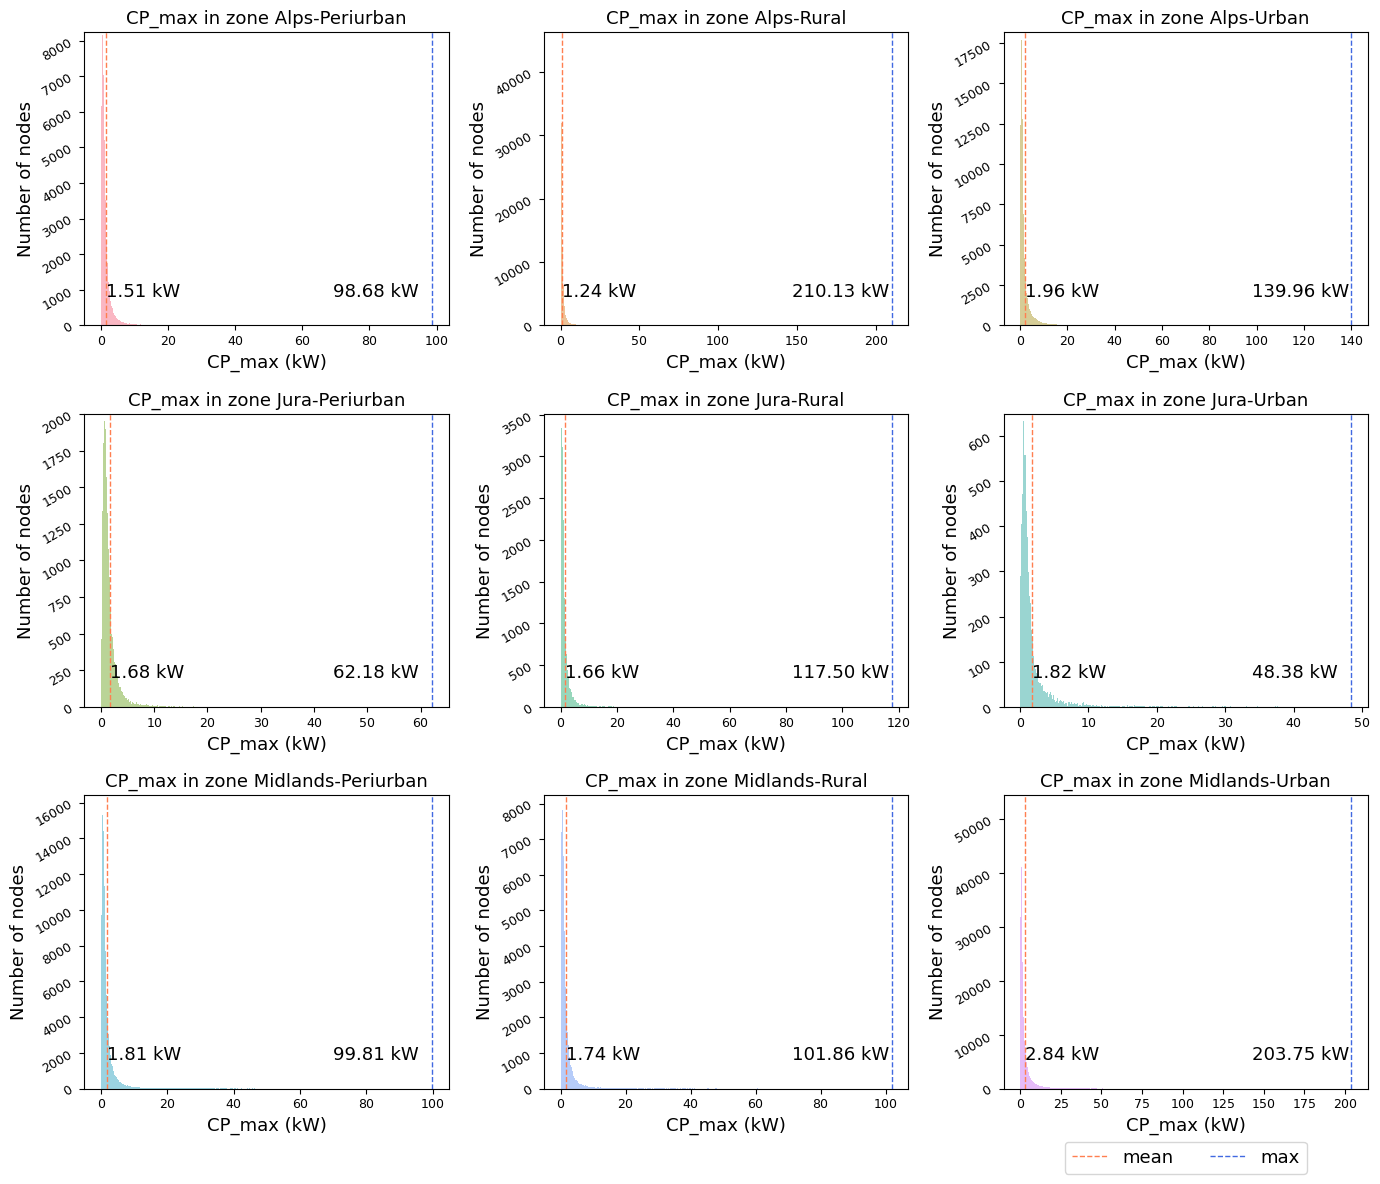

In [97]:
# data to look at
column = 'CP_max'

plt.figure(figsize=(14, 12))
unique_zones.sort()
for i in range(len(unique_zones)):
    zone = unique_zones[i]
    data = hist_in_zone(zone)
    data = data[data[column]!=0]
    plt.subplot(3, 3, i+1)
    counts, bins, patches = plt.hist(data[column], bins=1200, alpha=0.5,  color=colors[i])
    mean = data[column].mean()
    plt.axvline(mean, color='coral', linestyle='dashed', linewidth=1, label='mean')
    
    max = data[column].max()
    plt.axvline(max, color='royalblue', linestyle='dashed', linewidth=1, label='max')
    plt.xlabel(f'{column} (kW)')
    plt.ylabel('Number of nodes')
    # get the max count of the histogram
    max_count = counts.max()
    plt.ylim(0, max_count*1.01)
    plt.text(0.7*max, 0.1*max_count, f'{max:.2f} kW', rotation=0)
    plt.text(mean, 0.1*max_count, f'{mean:.2f} kW', rotation=0)
    plt.title(f'{column} in zone {zone}')
    # rotate y ticks
    plt.yticks(rotation=30)
# put the legend outside the plot, under the x-axis, and remove the frame, in the middle of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()  
if not os.path.exists(os.path.join(base_path, 'plots')):
    os.makedirs(os.path.join(base_path, 'plots'))
plt.savefig(os.path.join(base_path, 'plots', f'{column}_histogram.png'), dpi = 300, bbox_inches='tight')  
plt.show()

No data for municipality: 715


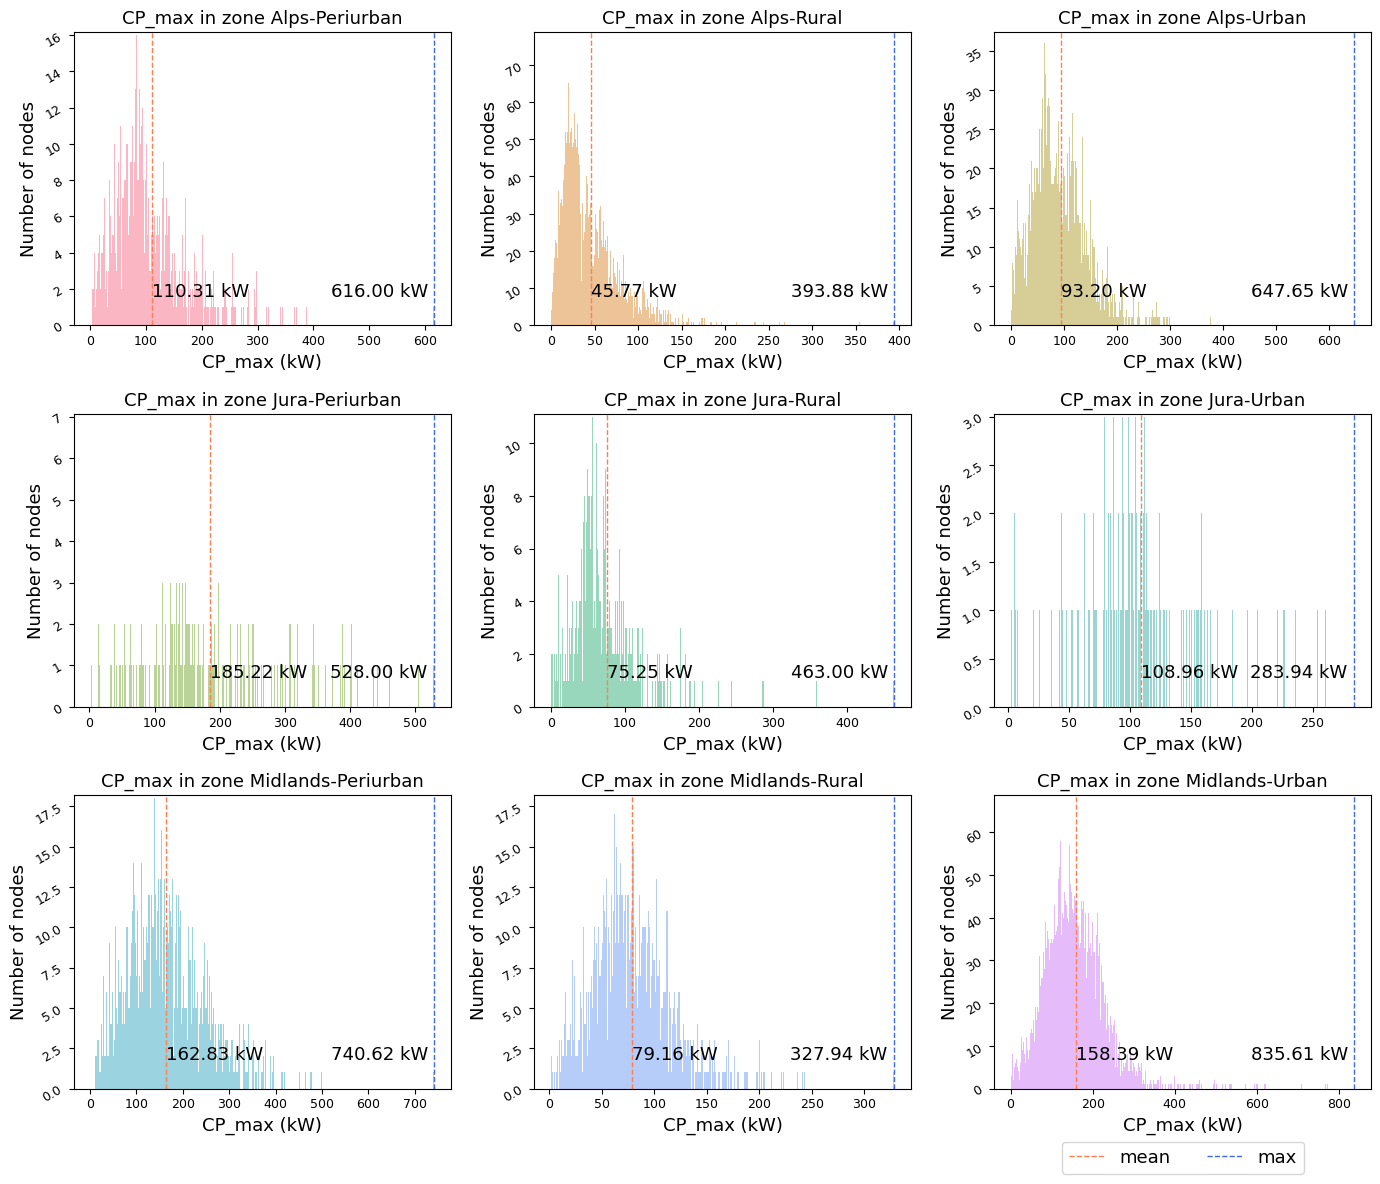

In [98]:
plt.figure(figsize=(14, 12))
for i in range(len(unique_zones)):
    zone = unique_zones[i]
    data = hist_in_zone(zone)
    # group by grid_name, delete node_name
    data = data.drop(columns=['node_name']).groupby('grid_name').sum()
    data.reset_index(inplace=True)
    
    plt.subplot(3, 3, i+1)
    counts, bins, patches = plt.hist(data[column], bins=1200, alpha=0.5,  color=colors[i])
    mean = data[column].mean()
    plt.axvline(mean, color='coral', linestyle='dashed', linewidth=1, label='mean')
    
    max = data[column].max()
    plt.axvline(max, color='royalblue', linestyle='dashed', linewidth=1, label='max')
    plt.xlabel(f'{column} (kW)')
    plt.ylabel('Number of nodes')

    max_count = counts.max()
    plt.ylim(0, max_count*1.01)
    plt.text(0.7*max, 0.1*max_count, f'{max:.2f} kW', rotation=0)
    plt.text(mean, 0.1*max_count, f'{mean:.2f} kW', rotation=0)
    plt.title(f'{column} in zone {zone}')
    plt.yticks(rotation=30)
# put the legend outside the plot, under the x-axis, and remove the frame, in the middle of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()  
plt.savefig(os.path.join(base_path, 'plots', f'{column}_histogram_grid.png'), dpi = 300, bbox_inches='tight')
plt.show()

plot histograms for CP_sum for 4 representative week

In [70]:
muni_path = os.path.join(data_path, 'EV_municipality')
def hist_in_zone_by_week(zone):
    zone_name = zone
    zone_data= zone_municipality[zone_municipality['zone']==zone_name]
    zone_muni = zone_data['municipality'].values
    data = pd.DataFrame()
    for muni in zone_muni:
        try:
            data_new = pd.read_csv(save_path+'/'+muni+'_percentage.csv')
            data_new = data_new.drop(columns=['CP_max', 'PU_max', 'PD_max', 'dmd'])
            EP = pd.read_csv(os.path.join(muni_path, muni, f'{muni}_EP.csv'))
            for i in range(4):
                data_add = data_new.copy()
                week = i + 1
                value = EP[EP['week']==week]['CP_sum_value'].values[0]
                data_add['EP'] = data_add['percentage']*value 
                data_add['week'] = week
                data = pd.concat([data, data_add], ignore_index=True)
        except:
            print('No data for municipality:', muni)
            continue
    return data

No data for municipality: 715


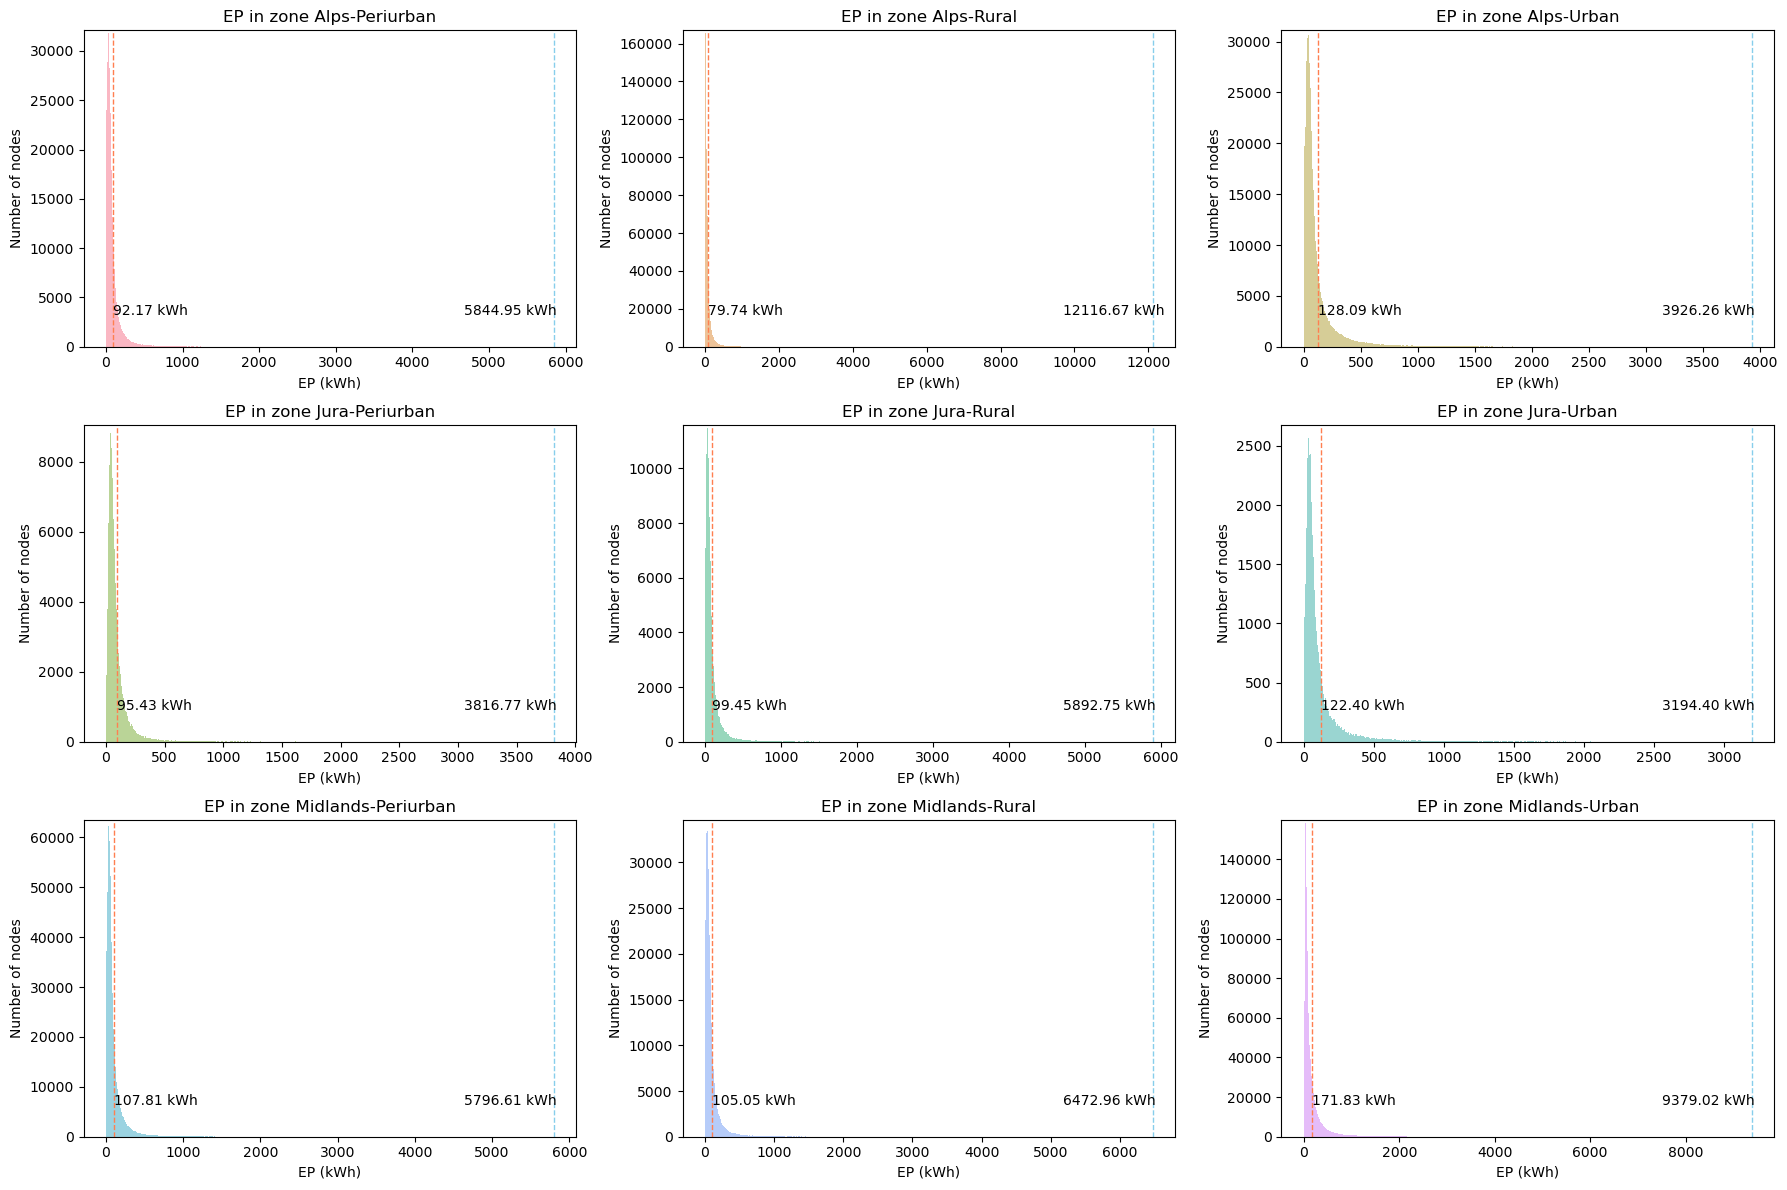

In [71]:
# plot
column = 'EP'
colors = sns.color_palette('husl', 10)
plt.figure(figsize=(18, 12))
unique_zones.sort()
for i in range(len(unique_zones)):
    zone = unique_zones[i]
    data = hist_in_zone_by_week(zone)
    data = data[data[column]!=0]
    plt.subplot(3, 3, i+1)
    counts, bins, patches = plt.hist(data[column], bins=1200, alpha=0.5, label=column, color=colors[i])
    mean = data[column].mean()
    plt.axvline(mean, color='coral', linestyle='dashed', linewidth=1)
    
    max = data[column].max()
    plt.axvline(max, color='skyblue', linestyle='dashed', linewidth=1)
    plt.xlabel(f'{column} (kWh)')
    plt.ylabel('Number of nodes')
    # get the max count of the histogram
    max_count = counts.max()
    plt.ylim(0, max_count*1.01)
    plt.text(0.8*max, 0.1*max_count, f'{max:.2f} kWh', rotation=0)
    plt.text(mean, 0.1*max_count, f'{mean:.2f} kWh', rotation=0)
    plt.title(f'{column} in zone {zone}')
plt.tight_layout()
plt.show()

No data for municipality: 715


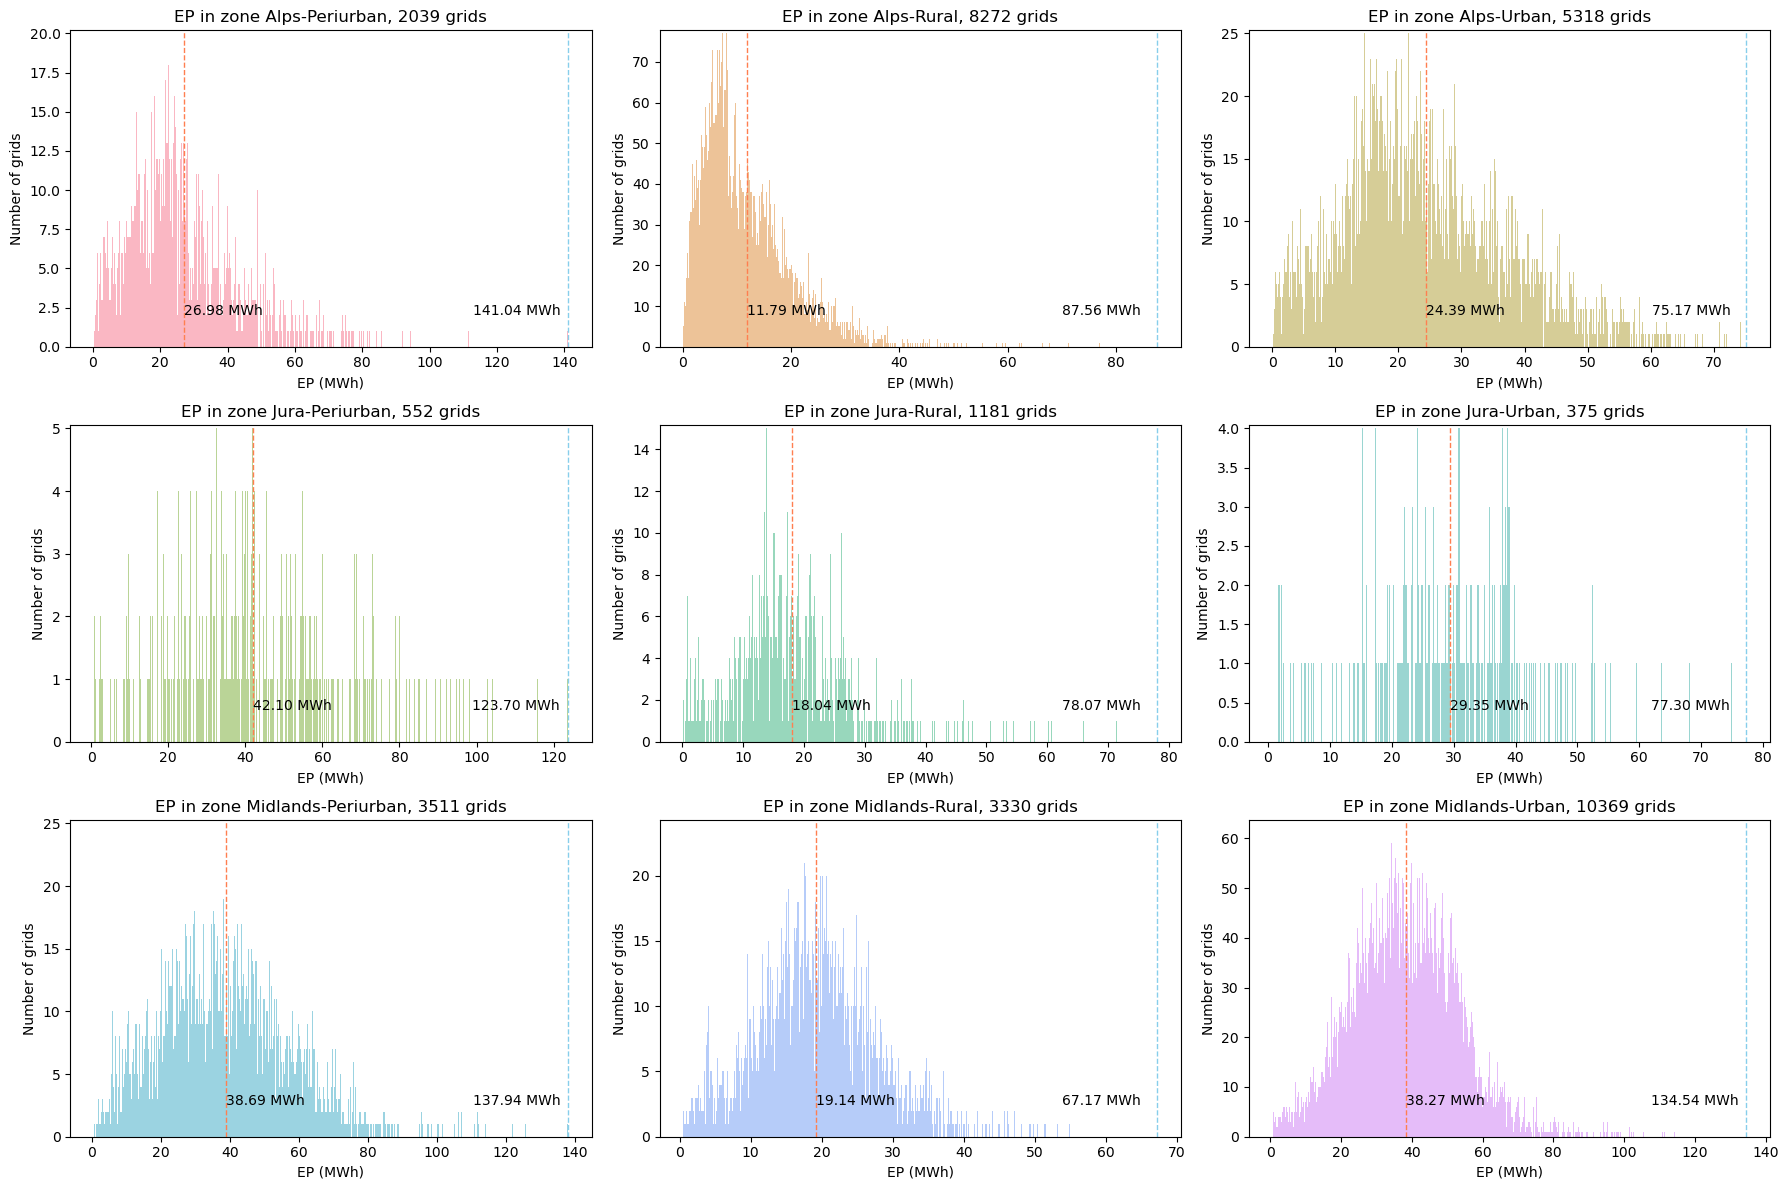

In [67]:
plt.figure(figsize=(18, 12))

for i in range(len(unique_zones)):
    zone = unique_zones[i]
    data = hist_in_zone_by_week(zone)
    # group by grid_name, delete node_name
    data = data.drop(columns=['node_name']).groupby('grid_name').sum()
    data['EP'] = data['EP']/1000 # change the unit to MWh
    data.reset_index(inplace=True)
    plt.subplot(3, 3, i+1)
    counts, bins, patches = plt.hist(data[column], bins=800, alpha=0.5, label=column, color=colors[i])
    mean = data[column].mean()
    plt.axvline(mean, color='coral', linestyle='dashed', linewidth=1)
    
    max = data[column].max()
    plt.axvline(max, color='skyblue', linestyle='dashed', linewidth=1)
    plt.xlabel(f'{column} (MWh)')
    plt.ylabel('Number of grids')
    # get the max count of the histogram
    max_count = counts.max()
    plt.ylim(0, max_count*1.01)
    plt.text(0.8*max, 0.1*max_count, f'{max:.2f} MWh', rotation=0)
    plt.text(mean, 0.1*max_count, f'{mean:.2f} MWh', rotation=0)
    n_grids = len(data['grid_name'].unique())
    plt.title(f'{column} in zone {zone}, {n_grids} grids')
plt.tight_layout()
plt.show()
